<a href="https://colab.research.google.com/github/Siba-mangal/Brain_tumor_detection/blob/main/Brain_Tumor_Detection_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            # image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [6]:
augmented_path = '/content/drive/MyDrive/dataset'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + '/yes' 
augmented_no = augmented_path + '/no'

IMG_WIDTH, IMG_HEIGHT = (256, 256)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1464
X shape is: (1464, 256, 256, 3)
y shape is: (1464, 1)


In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.25,random_state = 42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.25)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.25)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1098
number of development examples = 92
number of test examples = 274
X_train shape: (1098, 256, 256, 3)
Y_train shape: (1098, 1)
X_val (dev) shape: (92, 256, 256, 3)
Y_val (dev) shape: (92, 1)
X_test shape: (274, 256, 256, 3)
Y_test shape: (274, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [42]:
from keras.layers import Dropout
from tensorflow import keras
import tensorflow as tf

Buid Model

In [69]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    

    X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    # X = tf.keras.layers.Dropout(rate=0.2)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    

    X = Conv2D(128, (7, 7), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool2')(X)
    # X = tf.keras.layers.Dropout(rate=0.2)
    # X = keras.layers.Dropout(0.30)(X) # changed dropout rate 0.20 to 0.30
    X = keras.layers.Dropout(0.20)(X)
    # X=Dropout(0.2)(X)
 
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    
    return model

In [13]:
# def build_model(input_shape):
#     # Define the input placeholder as a tensor with shape input_shape. 
#     X_input = Input(input_shape)
#     X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
#     X = BatchNormalization(axis = 3, name = 'bn0')(X)
#     X = Activation('relu')(X) # 

#     # MAXPOOL
#     X = MaxPooling2D((2, 2), name='max_pool0')(X) # 
#     # X=Dropout(0.50)(X)


#     X = Conv2D(128, (5, 5), strides=(2, 2), name='conv1')(X)
#     X = BatchNormalization(axis=3, name='bn1')(X)
#     X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
#     X=Dropout(0.50)(X)

#     # FLATTEN X 
#     X = Flatten()(X) # shape=(?, 6272)
#     # FULLYCONNECTED
#     X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)


#     model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

#     return model

In [70]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [71]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 254, 254, 64)      1792      
                                                                 
 bn0 (BatchNormalization)    (None, 254, 254, 64)      256       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 127, 127, 64)      0         
                                                                 
 conv1 (Conv2D)              (None, 62, 62, 128)       204928    
                                                                 
 bn1 (BatchNormalization)    (None, 62, 62, 128

In [72]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [74]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("./Brain_Tumor_Detection_Models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [75]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time() 
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
34/35 [============================>.] - ETA: 0s - loss: 0.5258 - accuracy: 0.7987

35/35 [==============================] - 11s 177ms/step - loss: 0.5226 - accuracy: 0.8005 - val_loss: 2.3194 - val_accuracy: 0.4783
Epoch 2/20
34/35 [============================>.] - ETA: 0s - loss: 0.3086 - accuracy: 0.8658

35/35 [==============================] - 6s 179ms/step - loss: 0.3072 - accuracy: 0.8661 - val_loss: 0.4821 - val_accuracy: 0.7609
Epoch 3/20
34/35 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9127

35/35 [==============================] - 6s 165ms/step - loss: 0.2184 - accuracy: 0.9126 - val_loss: 0.3678 - val_accuracy: 0.8478
Epoch 4/20
34/35 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9430

35/35 [==============================] - 6s 168ms/step - loss: 0.1616 - accuracy: 0.9435 - val_loss: 0.3190 - val_accuracy: 0.8913
Epoch 5/20
34/35 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9706

35/35 [==============================] - 6s 159ms/step - loss: 0.0843 - accuracy: 0.9709 - val_loss: 0.6253 - val_accuracy: 0.6630
Epoch 6/20
34/35 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9697

35/35 [==============================] - 6s 168ms/step - loss: 0.0863 - accuracy: 0.9699 - val_loss: 0.2320 - val_accuracy: 0.9022
Epoch 7/20
34/35 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.9862

35/35 [==============================] - 6s 173ms/step - loss: 0.0493 - accuracy: 0.9863 - val_loss: 0.2946 - val_accuracy: 0.8587
Epoch 8/20
34/35 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9954

35/35 [==============================] - 5s 156ms/step - loss: 0.0257 - accuracy: 0.9954 - val_loss: 0.1502 - val_accuracy: 0.9565
Epoch 9/20
34/35 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9972

35/35 [==============================] - 7s 194ms/step - loss: 0.0214 - accuracy: 0.9973 - val_loss: 0.1374 - val_accuracy: 0.9565
Epoch 10/20
34/35 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9972

35/35 [==============================] - 6s 159ms/step - loss: 0.0179 - accuracy: 0.9973 - val_loss: 0.0958 - val_accuracy: 0.9674
Epoch 11/20
34/35 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9908

35/35 [==============================] - 6s 164ms/step - loss: 0.0349 - accuracy: 0.9909 - val_loss: 0.1305 - val_accuracy: 0.9783
Epoch 12/20
34/35 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9991

35/35 [==============================] - 6s 172ms/step - loss: 0.0161 - accuracy: 0.9991 - val_loss: 0.0917 - val_accuracy: 0.9783
Epoch 13/20
34/35 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9954

35/35 [==============================] - 5s 155ms/step - loss: 0.0220 - accuracy: 0.9954 - val_loss: 0.0731 - val_accuracy: 0.9674
Epoch 14/20
34/35 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000

35/35 [==============================] - 6s 173ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 0.9783
Epoch 15/20
34/35 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9991

35/35 [==============================] - 7s 190ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.0799 - val_accuracy: 0.9674
Epoch 16/20
35/35 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

35/35 [==============================] - 6s 187ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0743 - val_accuracy: 0.9783
Epoch 17/20
34/35 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

35/35 [==============================] - 5s 157ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0732 - val_accuracy: 0.9783
Epoch 18/20
34/35 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

35/35 [==============================] - 6s 182ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0790 - val_accuracy: 0.9783
Epoch 19/20
34/35 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

35/35 [==============================] - 6s 162ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 0.9674
Epoch 20/20
34/35 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

35/35 [==============================] - 5s 157ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0793 - val_accuracy: 0.9783
Elapsed time: 0:2:5.7


In [76]:
history = model.history.history

In [77]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [78]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

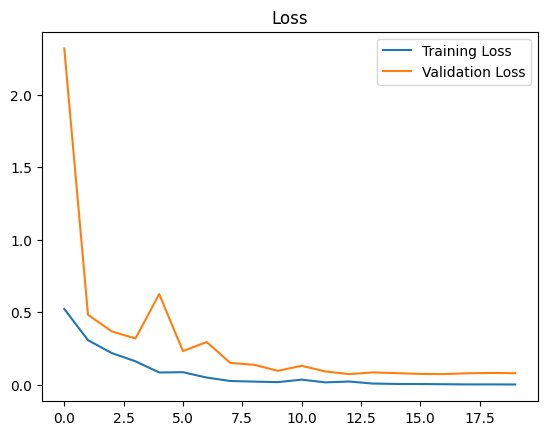

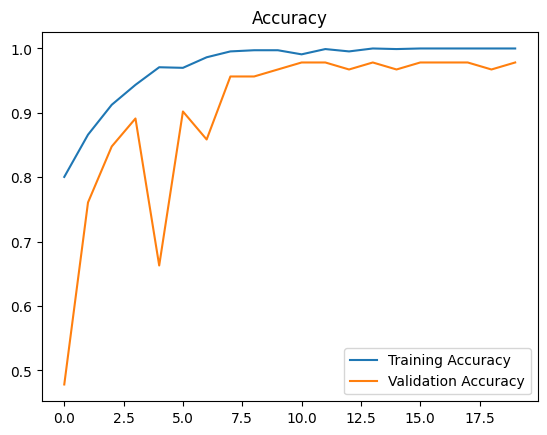

In [79]:
plot_metrics(history)

In [80]:
loss, acc = model.evaluate(x=X_test, y=y_test)

9/9 [==============================] - 1s 76ms/step - loss: 0.0675 - accuracy: 0.9745


In [81]:
print ("Test Loss = {}".format(loss))
print ("Test Accuracy = {}".format(acc))

Test Loss = 0.06754948943853378
Test Accuracy = 0.974452555179596


In [85]:
y_test_prob = model.predict(X_test)

9/9 [==============================] - 0s 29ms/step


In [86]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f1score)

0.9729729729729729


In [87]:
y_val_prob = model.predict(X_val)

3/3 [==============================] - 0s 29ms/step


In [88]:
f1score_val = compute_f1_score(y_val, y_val_prob)

In [89]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [90]:
data_percentage(y)

Number of examples:1464
Percentage of positive examples: 50.0%, number of pos examples: 732
Percentage of negative examples: 50.0%, number of neg examples: 732


In [91]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:1098
Percentage of positive examples: 51.09289617486339%, number of pos examples: 561
Percentage of negative examples: 48.90710382513661%, number of neg examples: 537
Validation Data:
Number of examples:92
Percentage of positive examples: 47.82608695652174%, number of pos examples: 44
Percentage of negative examples: 52.17391304347826%, number of neg examples: 48
Testing Data:
Number of examples:274
Percentage of positive examples: 46.35036496350365%, number of pos examples: 127
Percentage of negative examples: 53.64963503649635%, number of neg examples: 147


In [94]:
from PIL import Image
model_path = "/content/Brain_Tumor_Detection_Models/cnn-parameters-improvement-20-0.98.model"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Brain_dataset/pred/pred36.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((256, 256))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/256

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print('yes')
else:
  print('no')

# result = pred.argmax()
# result

1/1 [==============================] - 0s 185ms/step
no
